### Hypothesis - one

* Use model which trained with 30 people pictures collected from event photos.
* Test with image download from internet

1. Import required libraiy

In [43]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from scipy import misc
import cv2
import matplotlib.pyplot as plt
import numpy as np
import argparse
import facenet_uts
from align import detect_face
import os
from os.path import join as pjoin
import sys
import time
import copy
import math
import pickle
from sklearn.svm import SVC
from sklearn.externals import joblib
from facenet_uts import load_model
import sys
%matplotlib inline

2. Get the list of internet image data location

In [36]:
data = './data/'
from os import listdir
from os.path import isfile, join
file_location = []
file_name = listdir(data)
for each in file_name:
    f = listdir(join(data,each))
    for name in f:
        file_location.append(join(data,each,name))


['Jennifer_Lee', 'Chee-Chan_Keng', 'Abdul_Aziz_Abdul_Rahman', 'Shariq_Haseeb', 'Dr. Sharlene_Thiagarajah']


* Display the images

/home/wuthmone/miniconda3/envs/CV/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  import sys


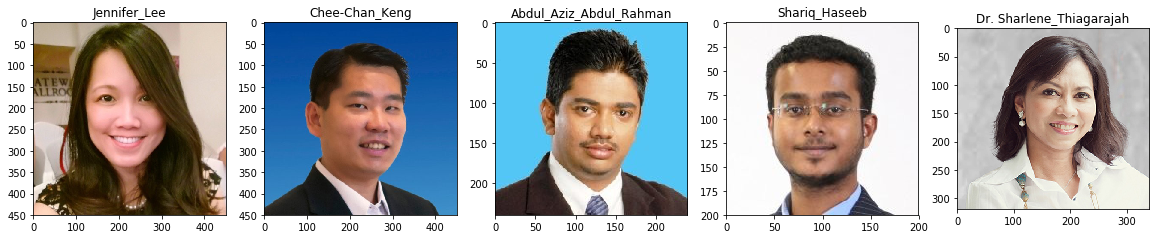

In [37]:
import PIL
images = [ PIL.Image.open(f) for f in file_location ]

def img2array(im):
    if im.mode != 'RGB':
        im = im.convert(mode='RGB')
    return np.fromstring(im.tobytes(), dtype='uint8').reshape((im.size[1], im.size[0], 3))

np_images = [ img2array(im) for im in images ]
# for img in np_images:
#     plt.figure()
#     plt.imshow(img)
    
    
# fig = plt.figure()
# fig.subplots_adjust(hspace=0.4, wspace=0.4)
# for  i,img in enumerate(np_images):
#     ax = fig.add_subplot(img)
#     ax.text(0.5, 0.5, file_location[i],fontsize=18, ha='center')


import numpy as np
import matplotlib.pyplot as plt

w=20
h=20
fig=plt.figure(figsize=(20, 20))
columns = 5
rows = 1
count = 0
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    ax= fig.add_subplot(rows, columns, i)
    ax.title.set_text(file_name[count])
    plt.imshow(np_images[count])
    count += 1
plt.show()

3. Get the model and classifier location

In [38]:
modeldir ='./model/20180408-102900.pb'
classifier_filename = './model/ft_v2__classifier.pkl'


4. Load the model and classifier,
5. Display Images

In [52]:
print('Creating networks and loading parameters')

with tf.Graph().as_default():
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
    with sess.as_default():
        pnet, rnet, onet = detect_face.create_mtcnn(sess, None)

        minsize = 20  # minimum size of face
        threshold = [0.6, 0.7, 0.7]  # three steps's threshold
        factor = 0.709  # scale factor
        margin = 44
        frame_interval = 3
        batch_size = 1000
        image_size = 182
        input_image_size = 160

        print('Loading feature extraction model')

        load_model(modeldir)

        images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
        embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
        phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
        embedding_size = embeddings.get_shape()[1]

        classifier_filename_exp = os.path.expanduser(classifier_filename)
        with open(classifier_filename_exp, 'rb') as infile:
            (model, class_names) = pickle.load(infile)
            print('load classifier file-> %s' % classifier_filename_exp)
            
        print('Start Recognition!')
        
        for each in file_location:
            frame = cv2.imread(each, 0)
            curTime = time.time()+1    # calc fps
            if frame.ndim == 2:
                frame = facenet_uts.to_rgb(frame)
                frame = frame[:, :, 0:3]
                bounding_boxes, _ = detect_face.detect_face(frame, minsize, pnet, rnet, onet, threshold, factor)
                nrof_faces = bounding_boxes.shape[0]
                print('Face Detected: %d' % nrof_faces)
                if nrof_faces > 0:
                    det = bounding_boxes[:, 0:4]
                    img_size = np.asarray(frame.shape)[0:2]

                    cropped = []
                    scaled = []
                    scaled_reshape = [] #to an window just select "General Appearance > Icon File". Problematic here is that Glade only shows image files locate
                    bb = np.zeros((nrof_faces, 4), dtype=np.int32)

                    for i in range(nrof_faces):
                        emb_array = np.zeros((1, embedding_size))

                        bb[i][0] = det[i][0]
                        bb[i][1] = det[i][1]
                        bb[i][2] = det[i][2]
                        bb[i][3] = det[i][3]

                        # inner exception
                        if bb[i][0] <= 0 or bb[i][1] <= 0 or bb[i][2] >= len(frame[0]) or bb[i][3] >= len(frame):
                            print('face is too close')
                            continue

                        cropped.append(frame[bb[i][1]:bb[i][3], bb[i][0]:bb[i][2], :])
                        cropped[i] = facenet_uts.flip(cropped[i], False)
                        scaled.append(misc.imresize(
                            cropped[i], (image_size, image_size), interp='bilinear'))
                        scaled[i] = cv2.resize(scaled[i], (input_image_size, input_image_size),
                                               interpolation=cv2.INTER_CUBIC)
                        scaled[i] = facenet_uts.prewhiten(scaled[i])
                        scaled_reshape.append(
                            scaled[i].reshape(-1, input_image_size, input_image_size, 3))
                        feed_dict = {
                            images_placeholder: scaled_reshape[i], phase_train_placeholder: False}
                        emb_array[0, :] = sess.run(embeddings, feed_dict=feed_dict)
                        predictions = model.predict_proba(emb_array)
                        best_class_indices = np.argmax(predictions, axis=1)
                        best_class_probabilities = predictions[np.arange(
                            len(best_class_indices)), best_class_indices]
                        print(best_class_probabilities)
        
                        result_names = class_names[best_class_indices[0]]
                        print(class_names)

                    

Creating networks and loading parameters
Loading feature extraction model
Model filename: ./model/20180408-102900.pb


/home/wuthmone/miniconda3/envs/CV/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator SVC from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


load classifier file-> ./model/ft_v2__classifier.pkl
Start Recognition!
Face Detected: 1


/home/wuthmone/miniconda3/envs/CV/lib/python3.6/site-packages/ipykernel_launcher.py:68: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


[0.15215022]
['Abd Raof bin Mat Shaari', 'Ahmad Hishamuddin Muhamed', 'Amran bin Hj Naemat', 'Dr  Nor Fazlina Iryani Binti Abdul Hamid', 'Dr Anuar Bin Musa', 'Dr Husniza binti Razali', 'Dr Jalil Bin Md Desa', 'Dr Sharlene Thiagarajah', 'Dr Sufian Mousa Ibrahim Mitani', 'Fakhrul Arifin Bin Mohd Afif', 'Ir Dr Abdul Aziz Bin Abdul Rahman', 'Keng Chee Chan', 'Mohamad Zainuddin bin Ahmad', 'Mohd Shafiq bin Alias', 'Mohd Shafri bin Kamaruddin', 'Nor Haziyana Binti Zakaria', 'Norashikin Binti Abdul Hamid', 'Norwati binti Mohd Aris', 'Romli Mohamad', 'Shariq Haseeb', 'Suriya Narayna Padhi', 'Wan Razli bin Wan Abdullah', 'Zaidi Abd Ghani @ Mukhtar', 'Zakaria Bin Ahmad']
Face Detected: 1


/home/wuthmone/miniconda3/envs/CV/lib/python3.6/site-packages/ipykernel_launcher.py:68: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


[0.19793863]
['Abd Raof bin Mat Shaari', 'Ahmad Hishamuddin Muhamed', 'Amran bin Hj Naemat', 'Dr  Nor Fazlina Iryani Binti Abdul Hamid', 'Dr Anuar Bin Musa', 'Dr Husniza binti Razali', 'Dr Jalil Bin Md Desa', 'Dr Sharlene Thiagarajah', 'Dr Sufian Mousa Ibrahim Mitani', 'Fakhrul Arifin Bin Mohd Afif', 'Ir Dr Abdul Aziz Bin Abdul Rahman', 'Keng Chee Chan', 'Mohamad Zainuddin bin Ahmad', 'Mohd Shafiq bin Alias', 'Mohd Shafri bin Kamaruddin', 'Nor Haziyana Binti Zakaria', 'Norashikin Binti Abdul Hamid', 'Norwati binti Mohd Aris', 'Romli Mohamad', 'Shariq Haseeb', 'Suriya Narayna Padhi', 'Wan Razli bin Wan Abdullah', 'Zaidi Abd Ghani @ Mukhtar', 'Zakaria Bin Ahmad']
Face Detected: 1


/home/wuthmone/miniconda3/envs/CV/lib/python3.6/site-packages/ipykernel_launcher.py:68: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


[0.16543334]
['Abd Raof bin Mat Shaari', 'Ahmad Hishamuddin Muhamed', 'Amran bin Hj Naemat', 'Dr  Nor Fazlina Iryani Binti Abdul Hamid', 'Dr Anuar Bin Musa', 'Dr Husniza binti Razali', 'Dr Jalil Bin Md Desa', 'Dr Sharlene Thiagarajah', 'Dr Sufian Mousa Ibrahim Mitani', 'Fakhrul Arifin Bin Mohd Afif', 'Ir Dr Abdul Aziz Bin Abdul Rahman', 'Keng Chee Chan', 'Mohamad Zainuddin bin Ahmad', 'Mohd Shafiq bin Alias', 'Mohd Shafri bin Kamaruddin', 'Nor Haziyana Binti Zakaria', 'Norashikin Binti Abdul Hamid', 'Norwati binti Mohd Aris', 'Romli Mohamad', 'Shariq Haseeb', 'Suriya Narayna Padhi', 'Wan Razli bin Wan Abdullah', 'Zaidi Abd Ghani @ Mukhtar', 'Zakaria Bin Ahmad']
Face Detected: 1


/home/wuthmone/miniconda3/envs/CV/lib/python3.6/site-packages/ipykernel_launcher.py:68: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


[0.12955437]
['Abd Raof bin Mat Shaari', 'Ahmad Hishamuddin Muhamed', 'Amran bin Hj Naemat', 'Dr  Nor Fazlina Iryani Binti Abdul Hamid', 'Dr Anuar Bin Musa', 'Dr Husniza binti Razali', 'Dr Jalil Bin Md Desa', 'Dr Sharlene Thiagarajah', 'Dr Sufian Mousa Ibrahim Mitani', 'Fakhrul Arifin Bin Mohd Afif', 'Ir Dr Abdul Aziz Bin Abdul Rahman', 'Keng Chee Chan', 'Mohamad Zainuddin bin Ahmad', 'Mohd Shafiq bin Alias', 'Mohd Shafri bin Kamaruddin', 'Nor Haziyana Binti Zakaria', 'Norashikin Binti Abdul Hamid', 'Norwati binti Mohd Aris', 'Romli Mohamad', 'Shariq Haseeb', 'Suriya Narayna Padhi', 'Wan Razli bin Wan Abdullah', 'Zaidi Abd Ghani @ Mukhtar', 'Zakaria Bin Ahmad']
Face Detected: 1
[0.17107264]
['Abd Raof bin Mat Shaari', 'Ahmad Hishamuddin Muhamed', 'Amran bin Hj Naemat', 'Dr  Nor Fazlina Iryani Binti Abdul Hamid', 'Dr Anuar Bin Musa', 'Dr Husniza binti Razali', 'Dr Jalil Bin Md Desa', 'Dr Sharlene Thiagarajah', 'Dr Sufian Mousa Ibrahim Mitani', 'Fakhrul Arifin Bin Mohd Afif', 'Ir Dr Abdu

/home/wuthmone/miniconda3/envs/CV/lib/python3.6/site-packages/ipykernel_launcher.py:68: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
